In [278]:
"""
Created By    : Aanan Schlief
Creation Date : 11/4/22
Course        : ATSC 528 - Atmospheric DA
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE] 

In this lab we take observations and plot those observations onto a map to show differences between different successive corrections
passes and Cressman analysis methods.For the first pass, the Cressman function 
is used to calculate weights for observations based on distance from the radius of influence and our background field. 
For the 2nd and 3rd passes, a bilinear interpolation function is used to calculate analysis 
values from the previous analysis pass at the observation stations. Then the code computes the differences between the
analyses plots. Finally, the  root mean square vlaues are calculated. Then, each analysis is plotted along with the three difference plots.  

"""
__author__    = "Jared Marquis"
__contact__   = "jared.marquis@und.edu"

In [279]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles 
import pandas as pd 

In [280]:
### Create function for Cressman Analysis ###
def cressmananalysis(number_radii, radii, gx, gy, fo,  back_ob = None, analysis_back=None):
    if number_radii == 0 or analysis_back == None:
        w = np.zeros((len(gx)))
        for i in range(len(gx)):
            rcalc = (gx[i]**2 + gy[i]**2) **0.5
            weightcalc = (radii**2 - rcalc**2)/(radii**2 + rcalc**2)
            w[i] = weightcalc
        
        cressa = np.nansum(w*fo)/np.sum(w) 
        return cressa
    else:
        cressa = analysis_back
        w = np.zeros(len(gx))
        for i in range(len(gx)):
            rcalc = (gx[i]**2 + gy[i]**2) **0.5
            weightcalc = (radii**2 - rcalc**2)/(radii**2 + rcalc**2)
            w[i] = weightcalc
        
        cressa = analysis_back + (np.nansum(w*(fo-back_ob))/np.nansum(w))
        return cressa

In [281]:
### Create function for bilinear interpolation ###
def bilinear_interp(x_obs, y_obs, a_obs, number_radii):
    
    xindex = (x_obs - 18.90) / 1.27
    yindex = (y_obs - (-6.3)) / 1.27    
    sq_matrix = np.matrix([[1, -1, -1, 1],[0, 0, 1, -1],[0, 1, 0, -1],[0, 0, 0, 1]])
    di = xindex - np.floor(xindex)
    dj = yindex - np.floor(yindex)
    xindex = int(np.floor(xindex))
    yindex = int(np.floor(yindex))
    a_matrix = np.matrix([1, di, dj, di*dj]).T
    f_matrix = np.matrix([a_obs[yindex, xindex, number_radii],
            a_obs[yindex,xindex+1,number_radii],
            a_obs[yindex+1, xindex,number_radii],
             a_obs[yindex+1, xindex+1,number_radii]])
    
    return f_matrix * sq_matrix * a_matrix

In [282]:
#Define Function to calculate Dmin 
def dmincalc(x_observ, y_observ): 
    minimum_radi = np.empty((len(x_observ)))
    for i in range(len(x_observ)): 
        relative_x = x_observ[i] - x_observ 
        relative_y = y_observ[i] - y_observ 
        relative_rad = (relative_x **2 + relative_y **2)**0.5 
        relative_rad = np.delete(relative_rad, i)
        minimum_radi[i] = np.amin(relative_rad)
    return np.mean(minimum_radi)

In [283]:
#Make method get the background obs 
def find_background_obs(radii, number_radii):
    #create empty background observations np array 
    back_obs = np.empty(len(x_observ))
    #do for loop to set background obs for future itertions
    for i in range(len(height_500)):
        if x_observ[i] > np.amin(gx) and \
            x_observ[i] < np.amax(gx) and \
            y_observ[i] > np.amin(gy) and \
            y_observ[i] < np.amax(gy):
                #print('In radius ' + str(i))
                back_obs[i] = bilinear_interp(x_observ[i], y_observ[i], analysis, number_radii)
        else: 
            rad = ((x_observ[i]-gx) ** 2 + (y_observ[i]-gy)**2)**0.5
            inds_radiia = np.where(rad <= radii)
            
            if np.amin(rad) > radii:
                back_obs[i] = np.nan
            else:
                relative_xb = (x_observ[i] - gx[inds_radiia]).flatten()
                relative_yb = (y_observ[i] - gy[inds_radiia]).flatten()
                heights = (analysis[:,:,number_radii][inds_radiia]).flatten()
                back_obs[i] = cressmananalysis(number_radii, radii, relative_xb, relative_yb, heights)
    return back_obs

In [284]:
### Read in observations ###
fi = pd.read_csv('./RAOBs_201903131200.txt', names=['Station ID', 'Latitude', 'Longitude', '500 mb Height', "Wind Direction", "Wind Speed"])
#make sure data is being read in properly 
#print(fi['500 mb Height'])

lon = fi['Longitude']
lat = fi['Latitude']
height_500 = fi['500 mb Height'] 
fi.head()

Station ID  Latitude  Longitude  500 mb Height  Wind Direction  Wind Speed
0       CWPL     51.47      -90.2         5460.0           285.0        29.0
1       CWQI     43.83      -66.0         5540.0           325.0        41.0
2       CWSE     53.55     -113.9         5360.0           280.0        12.0
3       CYAH     53.75      -73.6         5340.0           300.0        70.0
4       CYBK     64.30      -96.0         5220.0            95.0        17.0

In [285]:
### Set up analysis map with a 22x28 rectangular grid of points ###
#Set up grid size
x = 22
y = 28

#Set up grids 
gridx = np.arange(start = 18.90, stop = (18.90+x*1.27) - 1, step=1.27)
gridy = np.arange(start = -6.3, stop = (-6.3+y*1.27) - 1, step=1.27)

#use np.meshgrid to create gx and gy 
gx, gy = np.meshgrid(gridx, gridy)

In [286]:
### convert obs lat/long to x,y ### 
#Set Constants
roe = 6371 * 1e5
psi_0 = 60 * (np.pi/180)
scale = 1/(15e6)
llambda = -115

gridlat = (180/np.pi) * ((np.pi/2) - (2*np.arctan((np.sqrt((gx/scale)**2 + (gy/scale)**2))/(roe*(1+np.sin(psi_0)))))) 
gridlon = np.arctan(gy/gx) * (180/np.pi) + llambda

sigma = (1+np.sin(psi_0))/(1+np.sin((lat*(np.pi/180))))
r = roe * sigma * np.cos(lat*((np.pi/180))) * scale
y_observ = r*np.sin((lon*(np.pi/180))-llambda * (np.pi/180))
x_observ = r*np.cos(((lon*(np.pi/180)) - (llambda*(np.pi/180))))

#print(y_observ)
#print(x_observ)

In [287]:
#calculate dmin 
dmin = dmincalc(x_observ.values, y_observ.values)
radiis = np.array([4, 2.5, 1.5]) * dmin

In [288]:
#declare empty arrays for storage of values
analysis = np.empty((y, x, len(radiis)))
n_obs_arr = np.empty((y, x, len(radiis)))
background_obs = np.empty((len(height_500), len(radiis)))

In [289]:
### First analysis, no successive corrections ###
for i in range(len(gx)):
    for j in range(len(gx[0])):
        relative_x = gx[i, j] - x_observ
        relative_y = gy[i, j] - y_observ
        relative_rad = (relative_x**2 + relative_y**2) **0.5
        ind_radiis = np.where(relative_rad<radiis[0])[0]
        n_obs_arr[i, j, 0] = len(ind_radiis)
        
        x_k = relative_x[ind_radiis].values
        y_k = relative_y[ind_radiis].values
        fo = height_500[ind_radiis].values
            
        analysis[i, j, 0] = cressmananalysis(0, radiis[0], x_k, y_k, fo)


In [290]:
### Calculate background 1 and successive correction pass 1
background_obs[:,0] = find_background_obs(radiis[0], 0)
for i in range(len(gx)):
    for j in range(len(gx[0])):
        relative_x = gx[i, j] - x_observ
        relative_y = gy[i, j] - y_observ
        relative_rad = (relative_x**2 + relative_y**2) **0.5
        ind_radiis = np.where(relative_rad<radiis[1])[0]
        n_obs_arr[i, j, 1] = len(ind_radiis)
        
        x_k = relative_x[ind_radiis].values
        y_k = relative_y[ind_radiis].values
        fo = height_500[ind_radiis].values
        
        back_a = analysis[i,j,0]
        back_ob = background_obs[ind_radiis, 0]
        analysis[i, j, 1] = cressmananalysis(1, radiis[1], x_k, y_k, fo, analysis_back = back_a, back_ob = back_ob)

In [291]:
### Calculate background 2 and succesive correction pass 2
background_obs[:,1] = find_background_obs(radiis[1], 1)
for i in range(len(gx)):
    for j in range(len(gx[0])):
        relative_x = gx[i, j] - x_observ
        relative_y = gy[i, j] - y_observ
        relative_rad = (relative_x**2 + relative_y**2) **0.5
        ind_radiis = np.where(relative_rad<=radiis[2])[0]
        n_obs_arr[i, j, 2] = len(ind_radiis)
        
        x_k = relative_x[ind_radiis].values
        y_k = relative_y[ind_radiis].values
        fo = height_500[ind_radiis].values
        
        back_a = analysis[i,j,1]
        back_ob = background_obs[ind_radiis, 1]
        analysis[i, j, 2] = cressmananalysis(2, radiis[2], x_k, y_k, fo, analysis_back = back_a, back_ob = back_ob)

C:\Users\aanan\AppData\Local\Temp\ipykernel_26948\3959812864.py:20: RuntimeWarning: invalid value encountered in double_scalars
  cressa = analysis_back + (np.nansum(w*(fo-back_ob))/np.nansum(w))
C:\Users\aanan\AppData\Local\Temp\ipykernel_26948\3959812864.py:20: RuntimeWarning: invalid value encountered in double_scalars
  cressa = analysis_back + (np.nansum(w*(fo-back_ob))/np.nansum(w))
C:\Users\aanan\AppData\Local\Temp\ipykernel_26948\3959812864.py:20: RuntimeWarning: invalid value encountered in double_scalars
  cressa = analysis_back + (np.nansum(w*(fo-back_ob))/np.nansum(w))
C:\Users\aanan\AppData\Local\Temp\ipykernel_26948\3959812864.py:20: RuntimeWarning: invalid value encountered in double_scalars
  cressa = analysis_back + (np.nansum(w*(fo-back_ob))/np.nansum(w))
C:\Users\aanan\AppData\Local\Temp\ipykernel_26948\3959812864.py:20: RuntimeWarning: invalid value encountered in double_scalars
  cressa = analysis_back + (np.nansum(w*(fo-back_ob))/np.nansum(w))
C:\Users\aanan\AppDa

In [292]:
#calculate background 3 and RMS values
back_obs = find_background_obs(radiis[2], 2)

background_obs[:,2]= find_background_obs(radiis[2], 2)
for j in range(len(gx[0])):
    relative_x = gx[i, j] - x_observ
    relative_y = gy[i, j] - y_observ
    relative_r = (relative_x**2 + relative_y**2) **0.5
    index_radiis = np.where(relative_r<=radiis[2])[0]
    n_obs_arr[i, j, 2] = len(index_radiis)
    
    x_k = relative_x[index_radiis].values
    y_k = relative_y[index_radiis].values
    fo = height_500[index_radiis].values
        
    back_a = analysis[i,j,2]
    back_ob = background_obs[index_radiis, 2]

In [293]:
### Calculate RMS values 
background_obs1=(background_obs[:,0])
background_obs2=(background_obs[:,1])
background_obs3=(background_obs[:,2])

#Pass1
diff_1 = (height_500 - background_obs1)**2
diff_1 = subtract_1[~np.isnan(diff_1)]
rmsval_1 = np.sqrt((np.sum(diff_1))/ len(diff_1))

#Pass2
diff_2 = (height_500 - background_obs2)**2
diff_2 = subtract_2[~np.isnan(diff_2)]
rmsval_2 = np.sqrt((np.sum(diff_2))/ len(diff_2))

#Pass3
subtract_3 = (height_500 - background_obs3)**2
subtract_3 = subtract_3[~np.isnan(subtract_3)]
rmsval_3 = np.sqrt((np.sum(subtract_3))/ len(subtract_3))

print(rmsval_1,rmsval_2,rmsval_3)
rms_array=[rmsval_1,rmsval_2,rmsval_3]

74.54329800402633 35.12766126581716 14.860428194570517


In [294]:
### Calculate Analysis Differences
difference1 = analysis[:,:,1] - analysis[:,:,0]
difference2 = analysis[:,:,2] - analysis[:,:,0]
difference3 = analysis[:,:,2] - analysis[:,:,1]

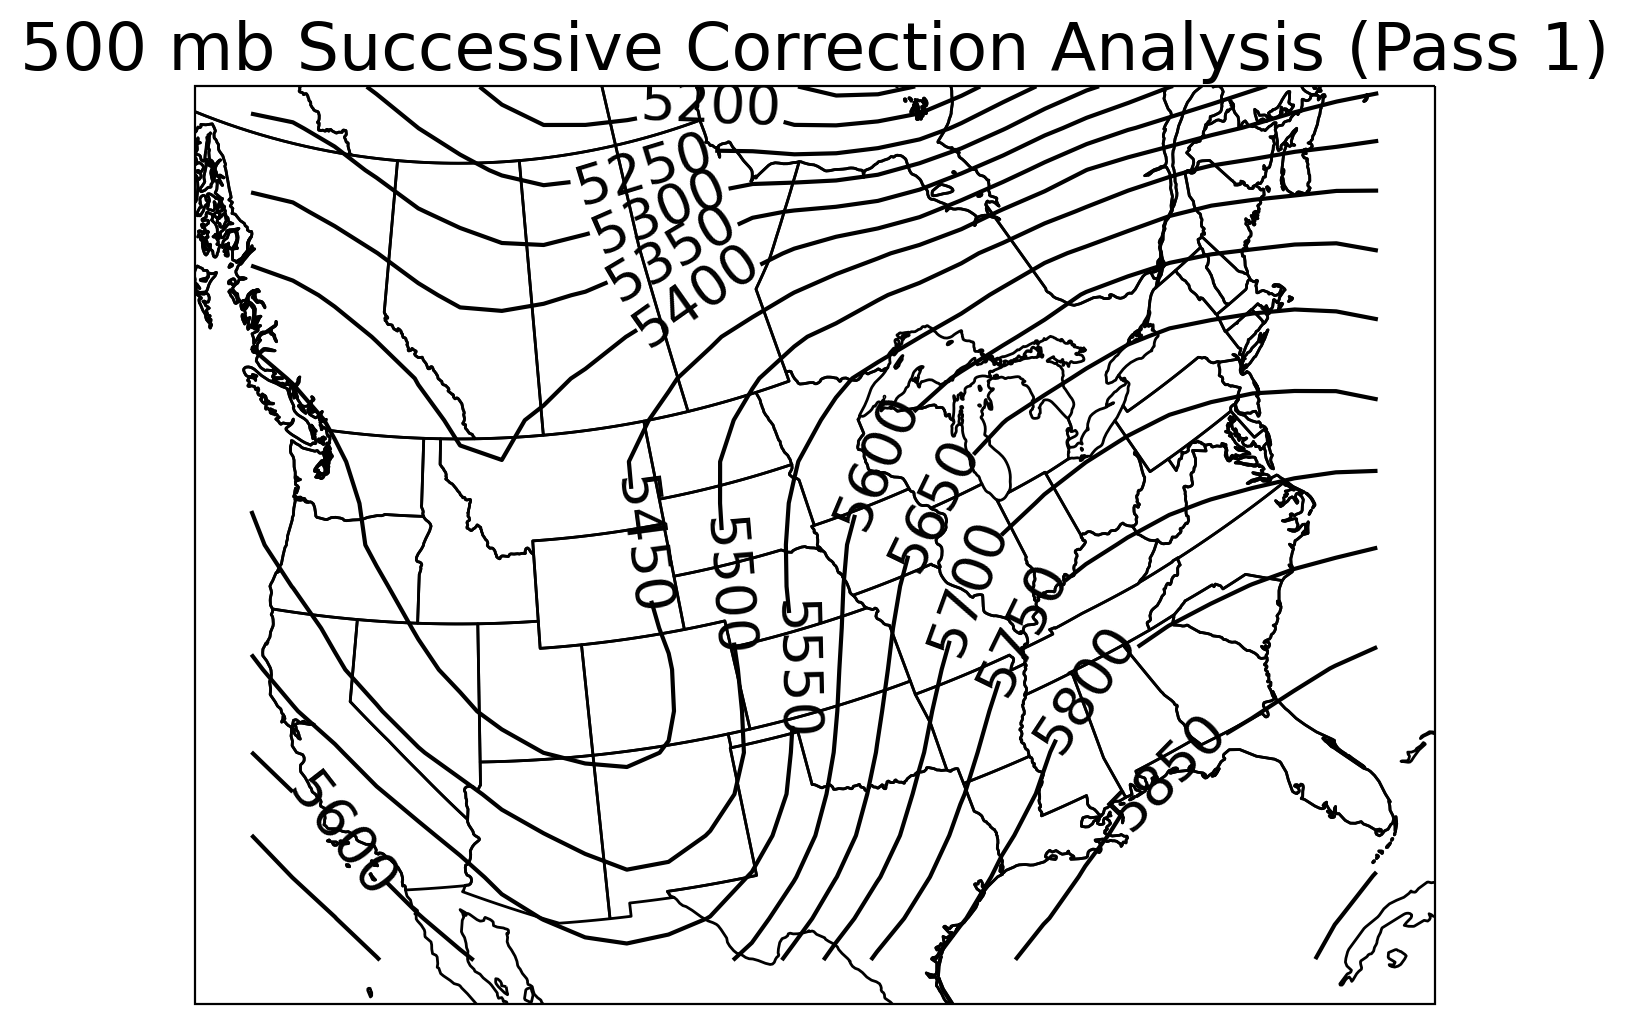

In [295]:
### Plot 500 mb Analysis Successive Corections 1
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(gridlon,gridlat,analysis[:,:,1],colors='black',levels=np.arange(0,8000,50),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,50))
plt.title('500 mb Successive Correction Analysis (Pass 1)')
plt.savefig('500 mb Successive Correction Analysis (Pass 1)')
plt.show()

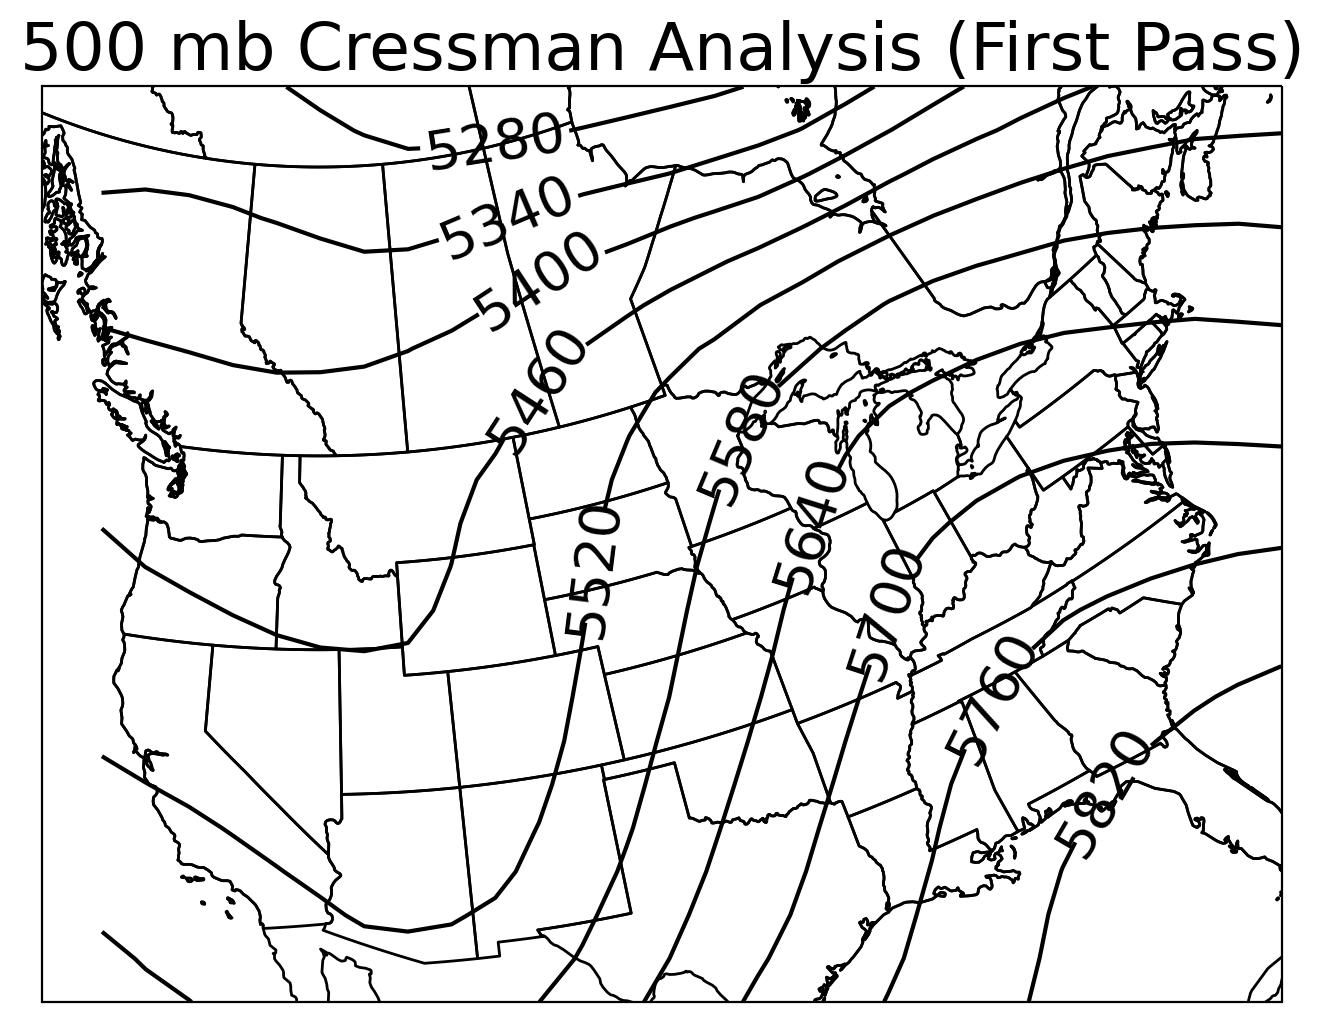

In [296]:
### Plot Cressman Analysis ###
fig = plt.figure(figsize = (8,8), dpi = 200)
proj = ccrs.Stereographic(central_longitude=-115, central_latitude=90, true_scale_latitude = 60)
ax1 = plt.subplot(111, projection = proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(gridlon, gridlat, analysis[:,:,0], colors = "black", levels = np.arange(0,8000,60), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels=np.arange(0,8000,60))
plt.title('500 mb Cressman Analysis (First Pass)')
plt.savefig('500 mb Cressman Analysis (First Pass)')
plt.show()

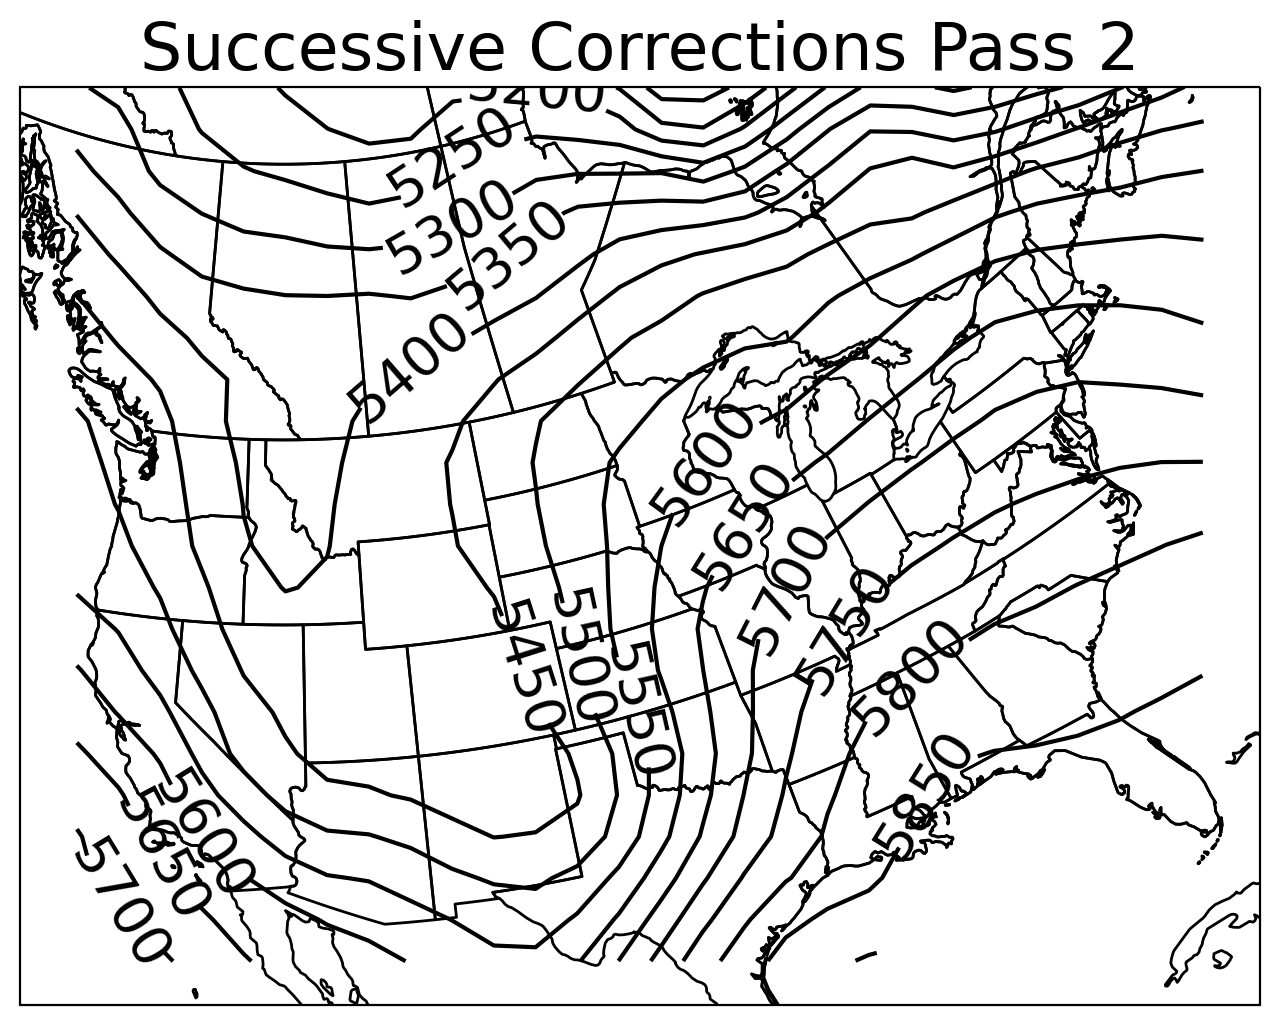

In [297]:
### Plot Pass 2
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

plotpass2 = ax1.contour(gridlon,gridlat,analysis[:,:,2],colors='black',levels=np.arange(0,8000,50),transform=ccrs.PlateCarree())
plt.clabel(plotpass2,levels=np.arange(0,8000,50))
plt.title('Successive Corrections Pass 2')

plt.show()


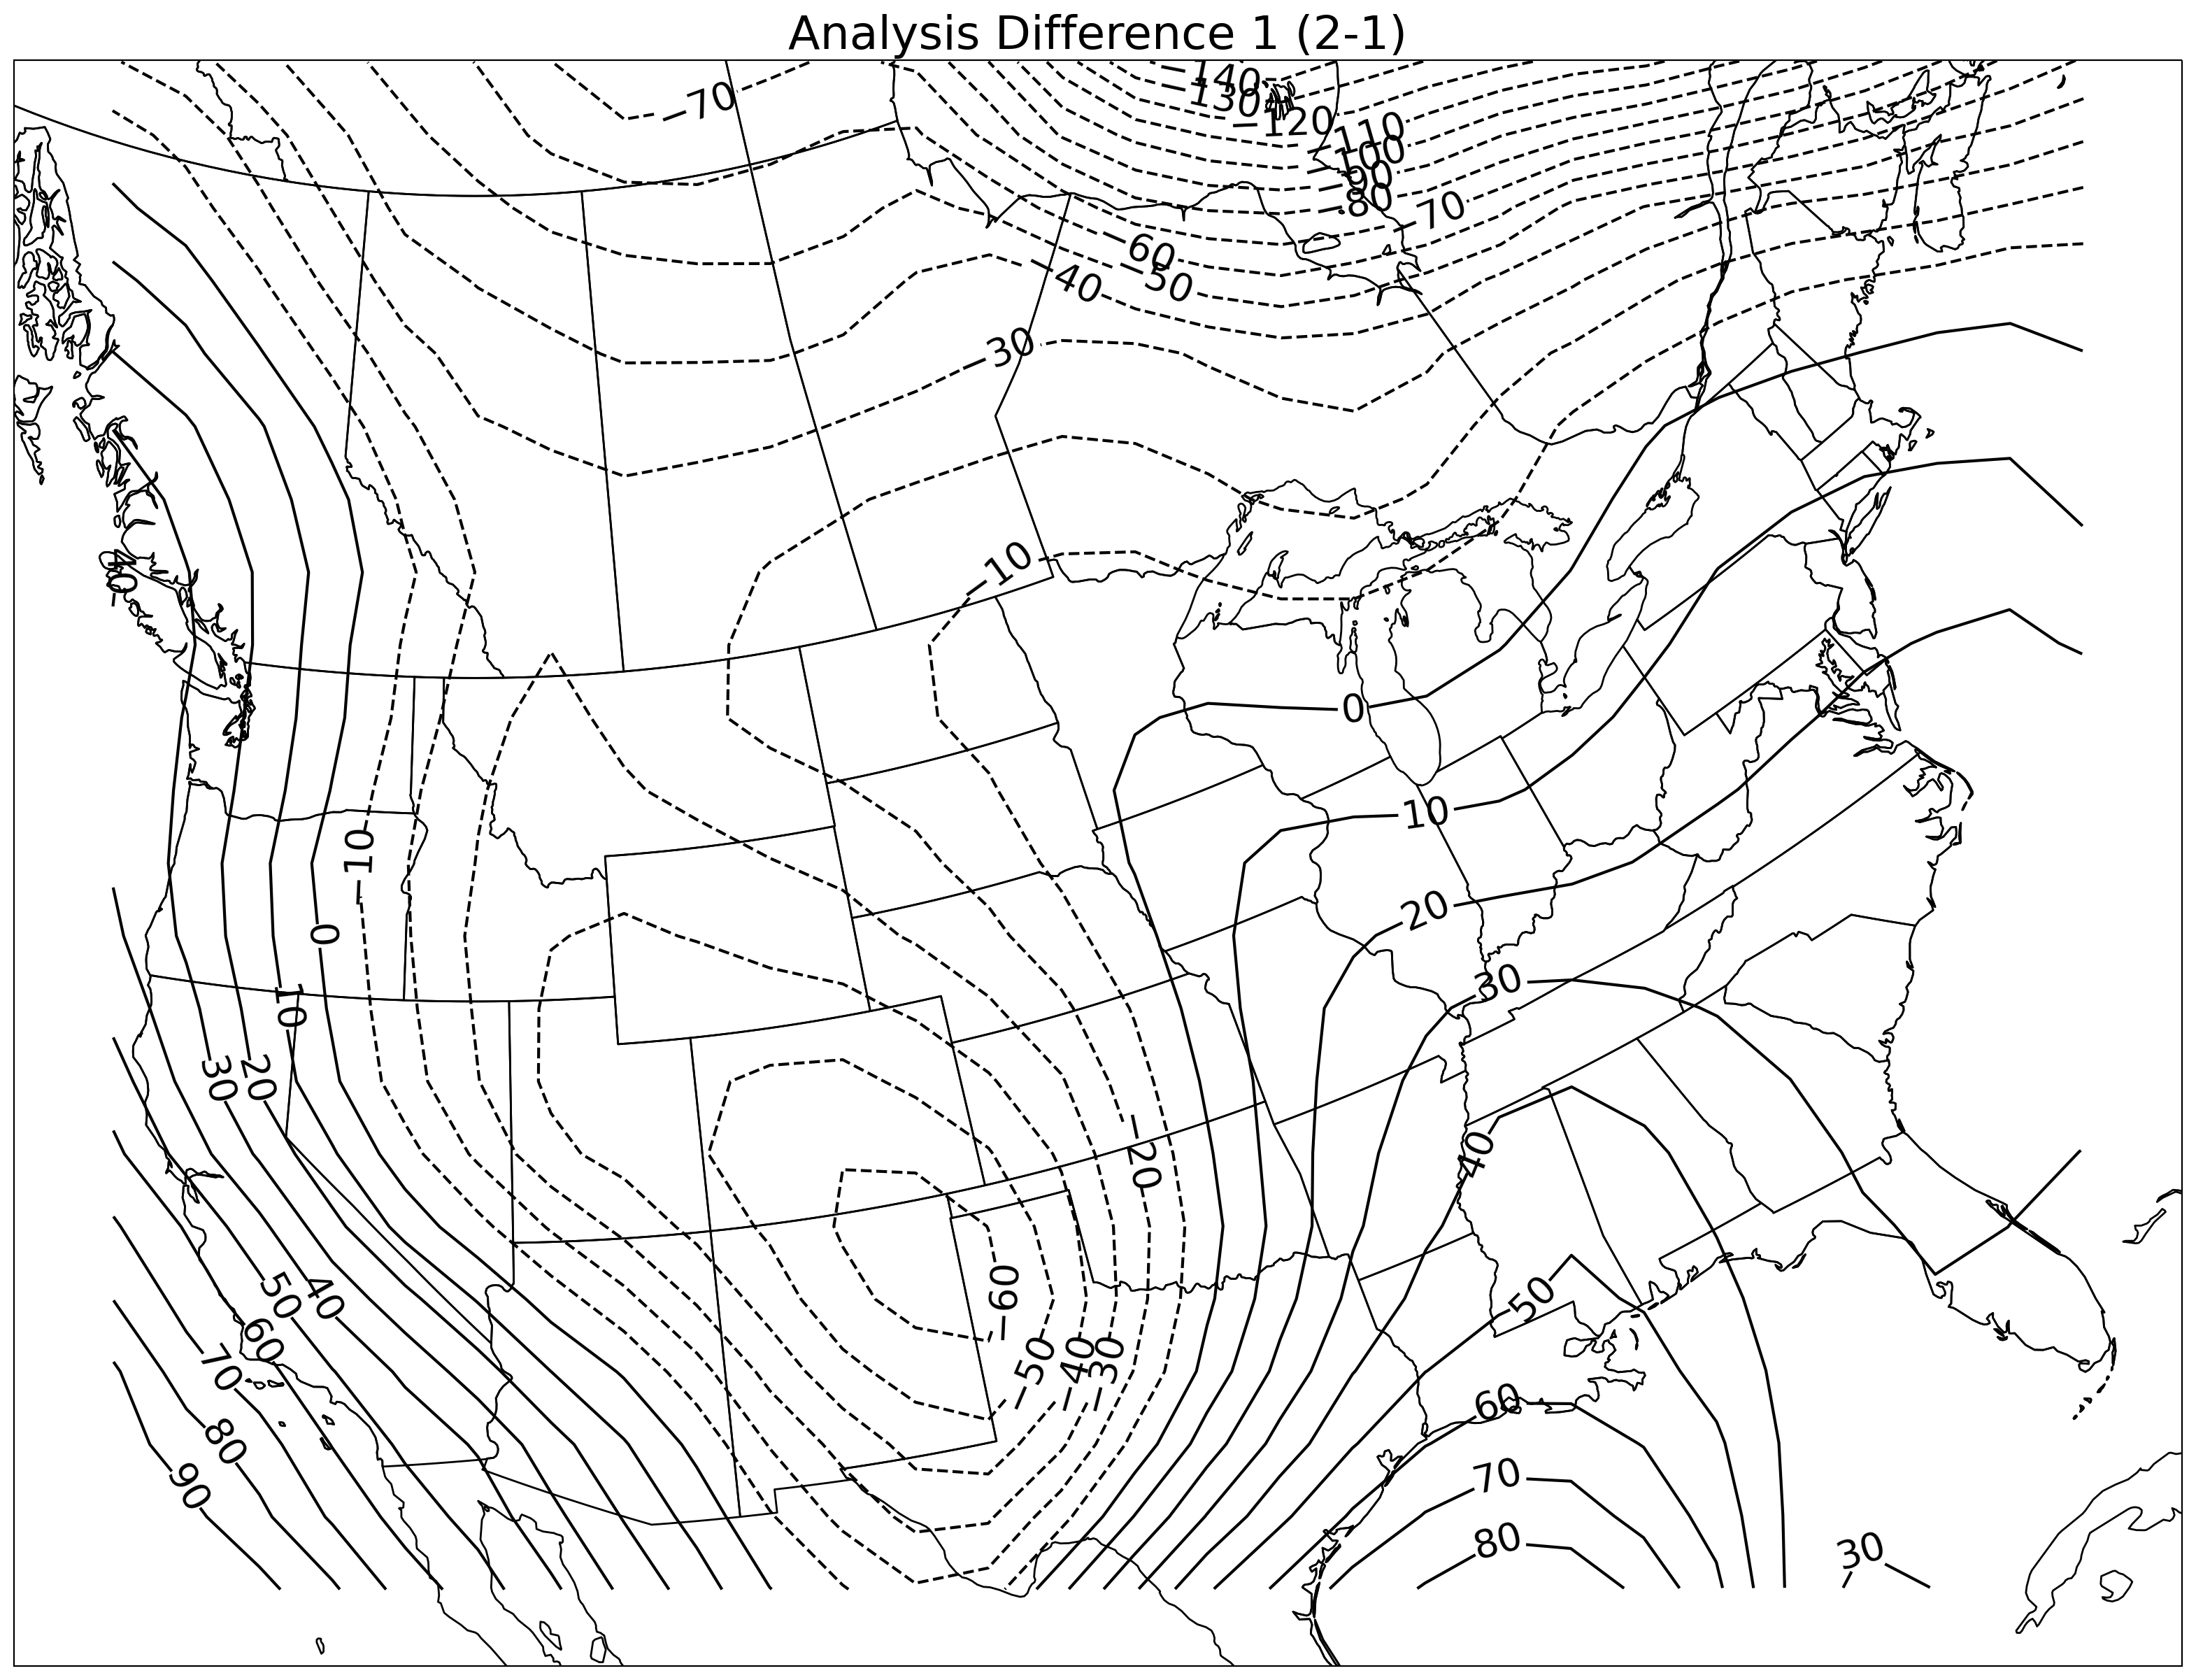

In [298]:
###Plot Analysis Difference 2-1
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(20,20),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

plt.rcParams.update({'font.size':20})
plotdiff1 = ax1.contour(gridlon,gridlat,difference1,colors='black',levels=np.arange(-8000,8000,10),transform=ccrs.PlateCarree())
plt.clabel(plotdiff1,levels=np.arange(-8000,8000,10))
plt.title('Analysis Difference 1 (2-1)')
plt.savefig('Analysis 2-Analysis 1')
plt.show()

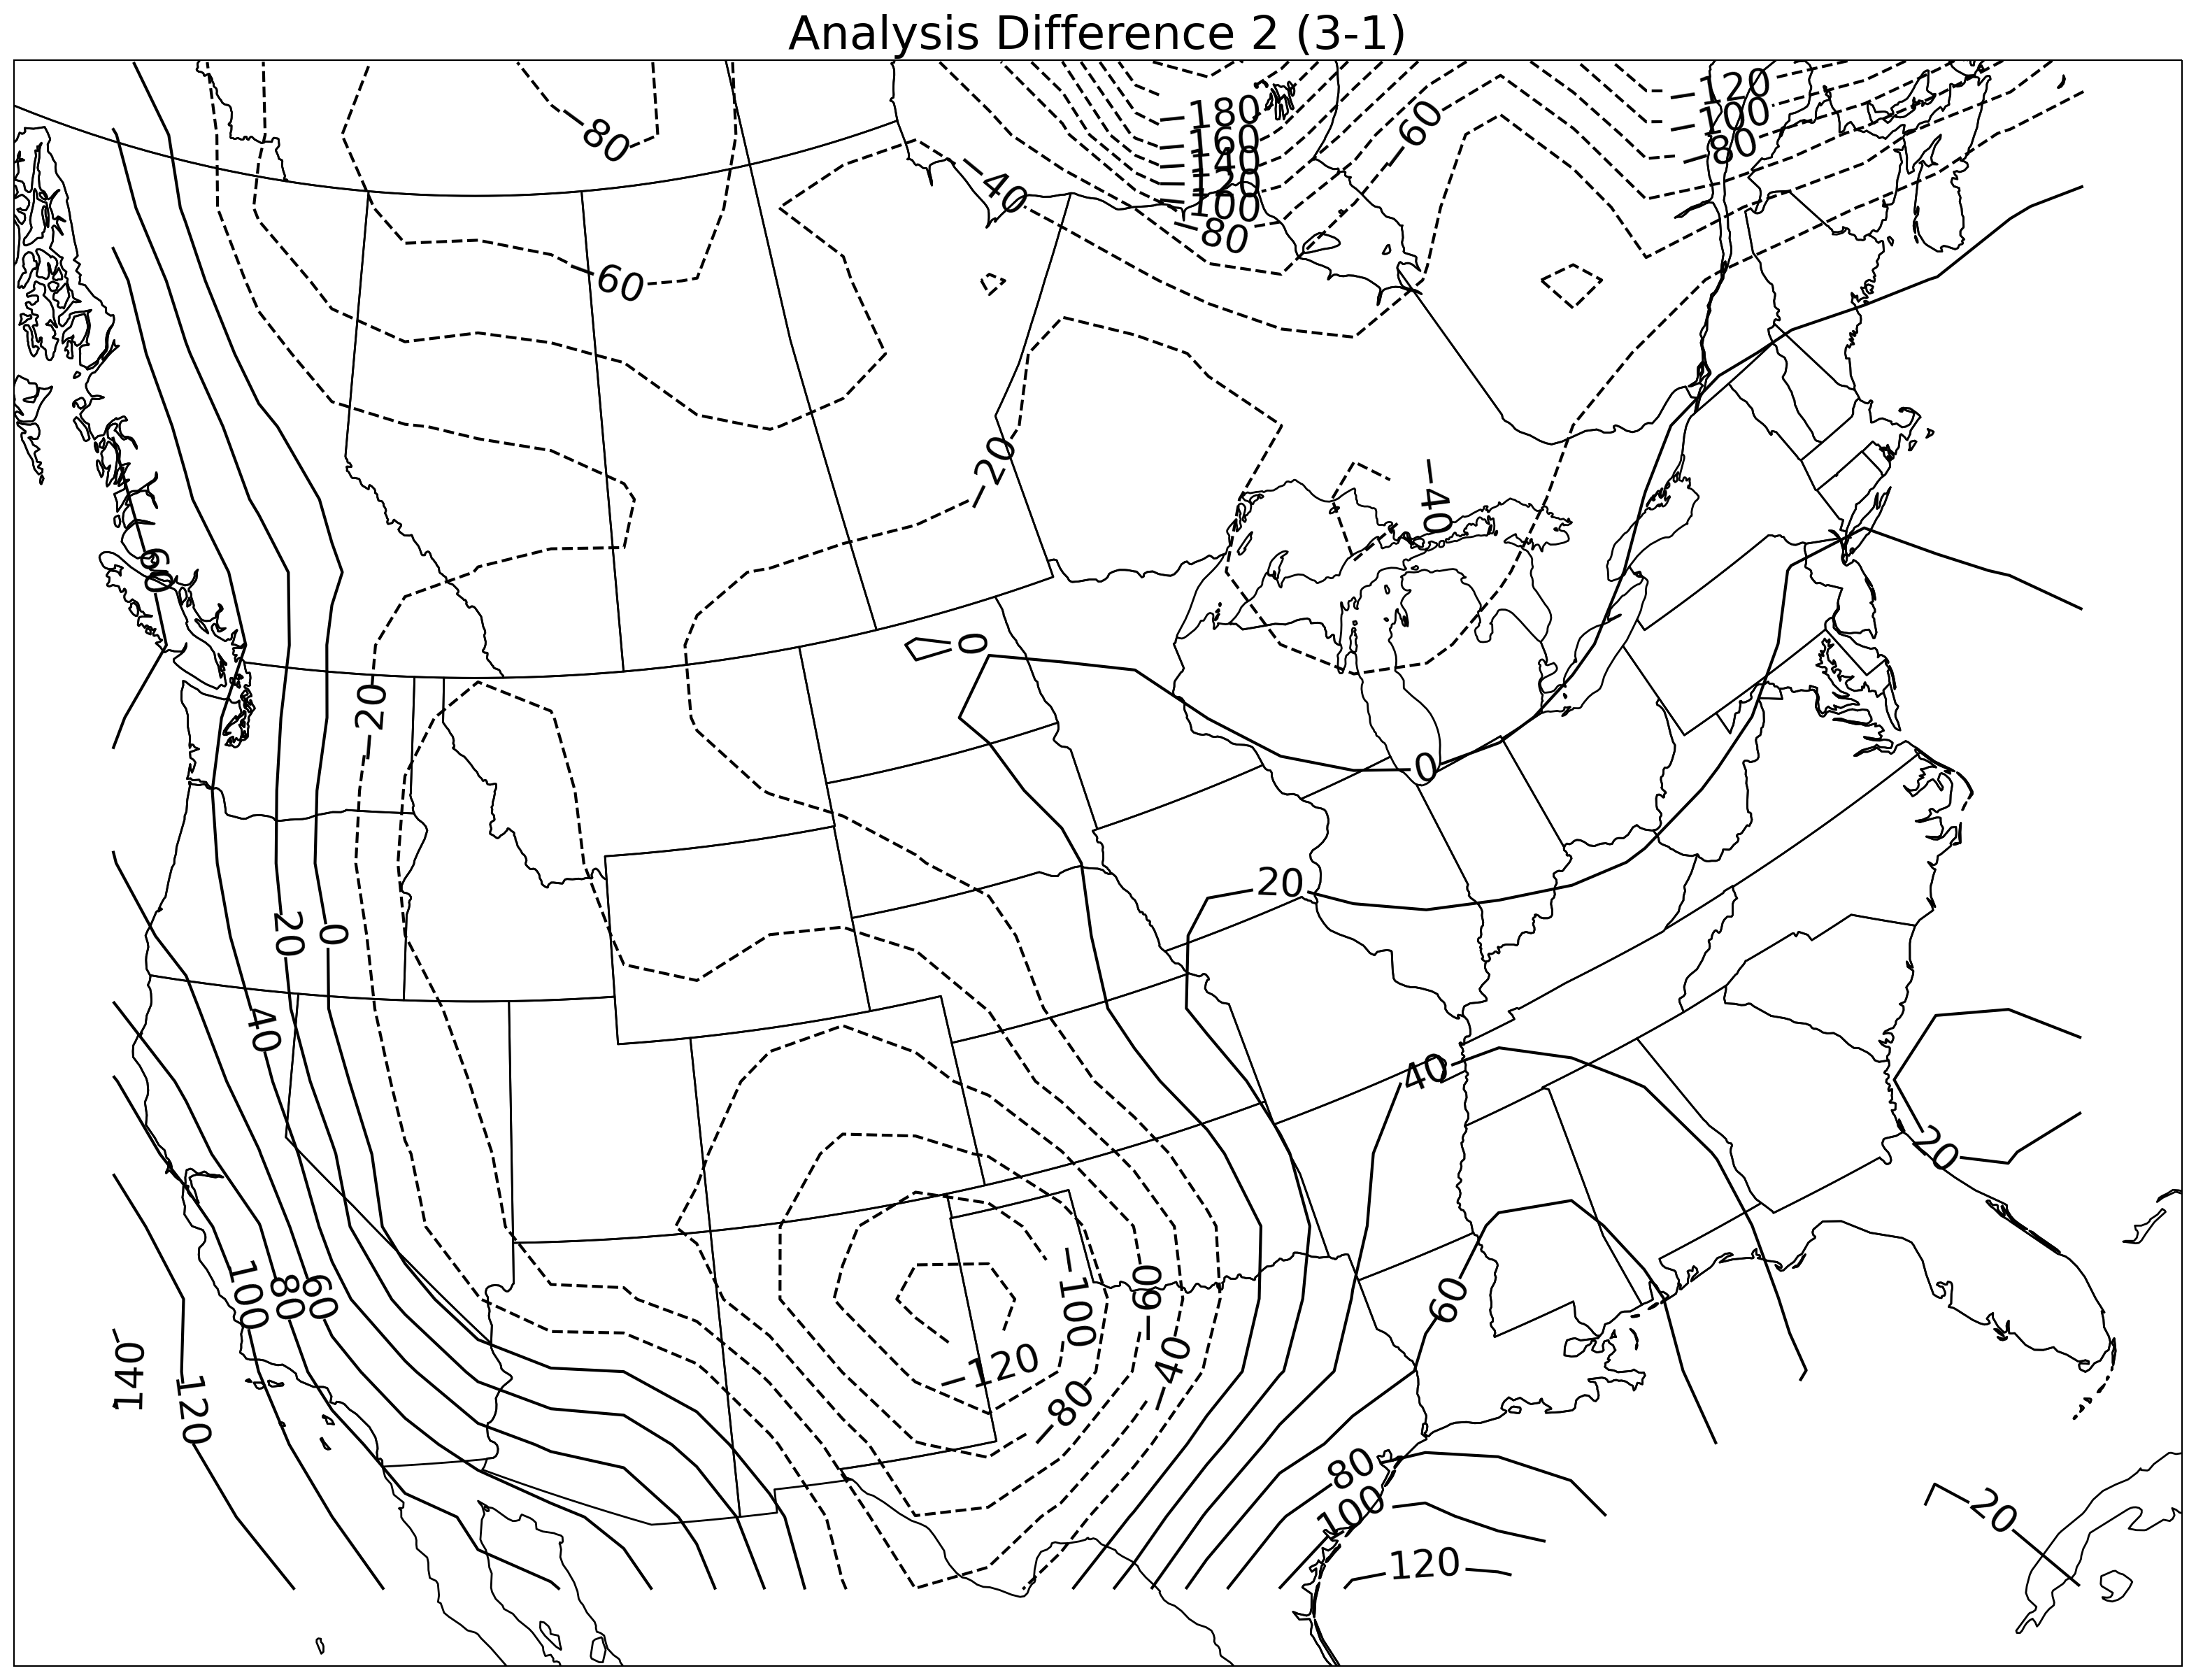

In [299]:
### Plot Analysis Difference 3-1 ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(20,20),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)


plotdiff1 = ax1.contour(gridlon,gridlat,difference2,colors='black',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(plotdiff1,levels=np.arange(-8000,8000,20))
plt.title('Analysis Difference 2 (3-1)')
plt.savefig('Analysis 3-Analysis 1')
plt.show()

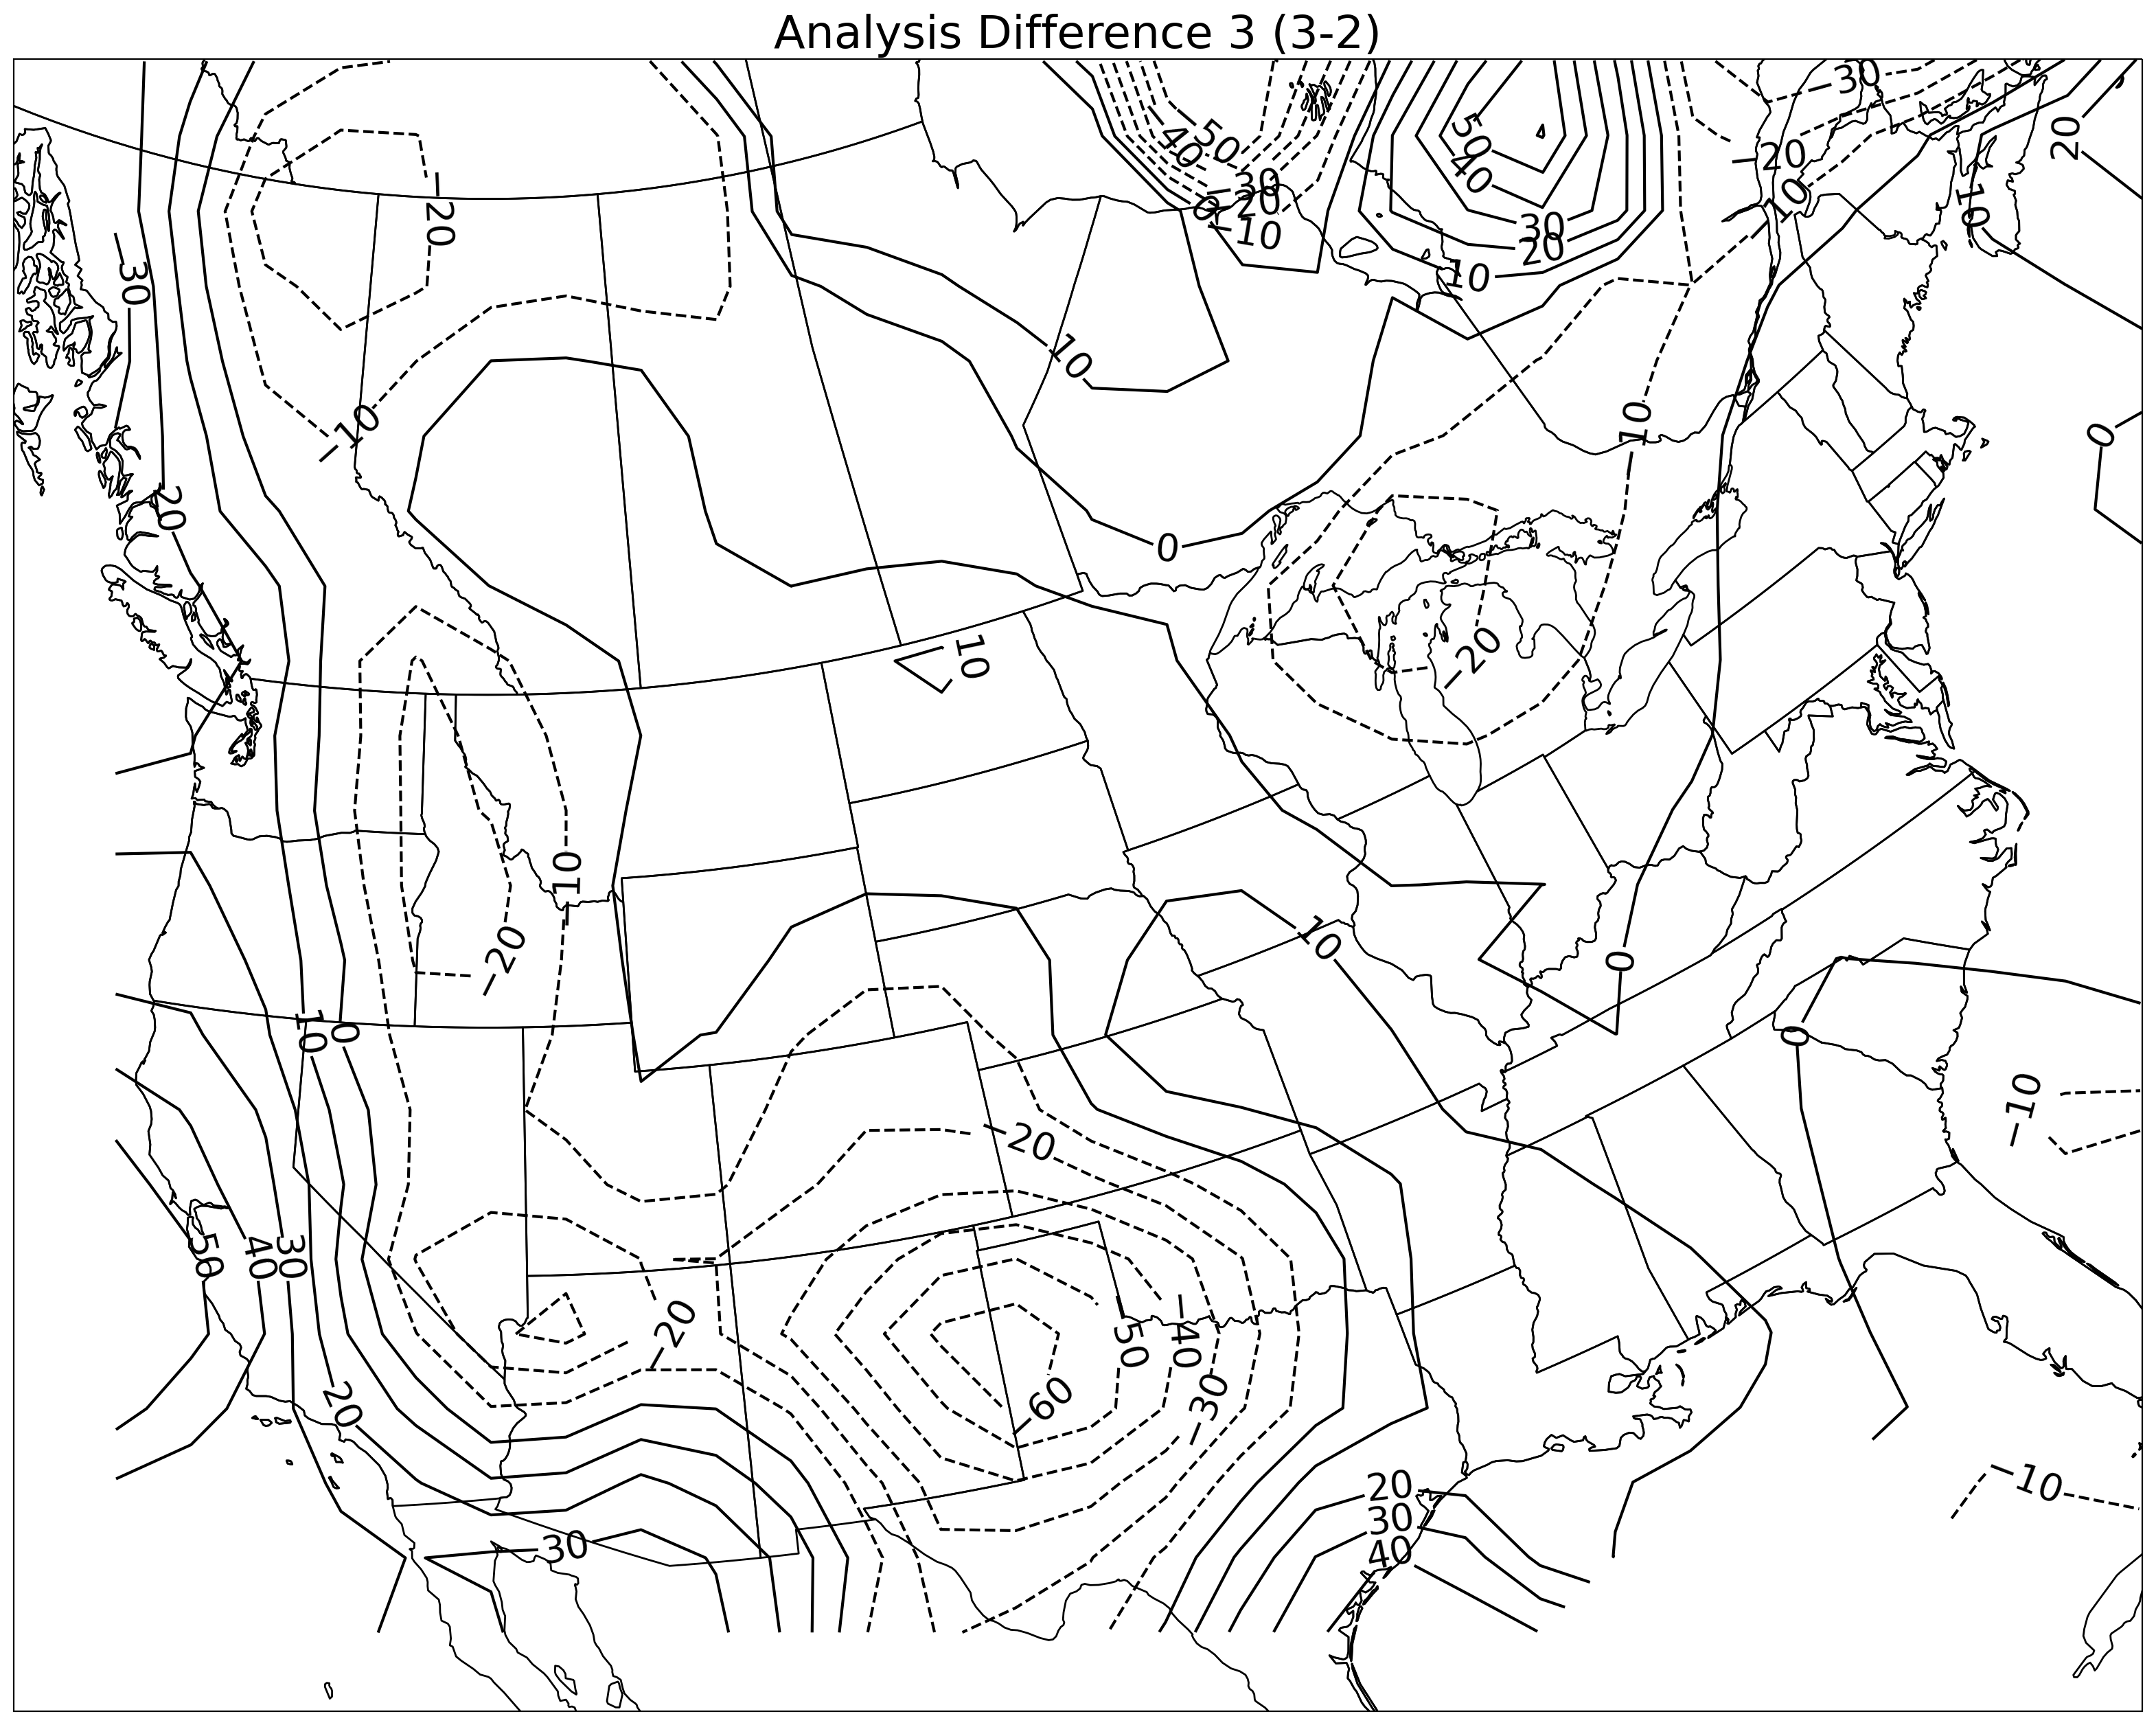

In [300]:
### Plot Analysis Difference 3-2
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(20,20),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

plt.rcParams.update({'font.size':20})
plotdiff1 = ax1.contour(gridlon,gridlat,difference3,colors='black',levels=np.arange(-8000,8000,10),transform=ccrs.PlateCarree())
plt.clabel(plotdiff1,levels=np.arange(-8000,8000,10))
plt.title('Analysis Difference 3 (3-2)')
plt.savefig('Analysis 3-Analysis 2')
plt.show()

In [301]:
### Store the analyses in text files ###
analysis_1= open("analysis_1.text","w+")
analysis1=str(analysis[:,:,0])
analysis_1.write(analysis1)
analysis_1.close()

analysis_2= open("analysis_2.text","w+")
analysis2=str(analysis[:,:,1])
analysis_2.write(analysis2)
analysis_2.close()

analysis_3= open("analysis_3.text","w+")
analysis3=str(analysis[:,:,2])
analysis_3.write(analysis3)
analysis_3.close()

In [302]:
### Store the difference fields in text files ###
difference_file1=open("difference1_2_1.txt","w+")
differ1=str(difference1)
difference_file1.write(differ1)
difference_file1.close()

difference_file2=open("difference2_3_2.txt","w+")
differ2=str(difference2)
difference_file2.write(differ2)
difference_file2.close()

difference_file3=open("difference3_3_1.txt","w+")
differ3=str(difference3)
difference_file3.write(differ3)
difference_file3.close()

In [303]:
### Store RMS values in text file ### 
file = open('rms_file.txt','w+')
rmsval=str(rms_array)
file.write(rmsval)
file.close()

In [304]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
        In the contoured analysis seen above we can see a trough over the Western United States with ridings taking place on the 
        Eastern half of the United States. The 1st pass succesive corrections analysis plot shows 
        features that are more smoothed out than the 2nd pass successive corrections plot. 

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    As talked about in 1). the first pass succesive corrections plot is more smoothed out thatn the 2nd pass successive corections plot 
    The 2nd pass also shows a deeper trough that extends farther into the Southern US than that of the 1st pass plot. But, this likely because of how we are weighting these 
    functions that can create the differences in the smoothness of our contours 
    
    
3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    
    When we increase the number of succesive correction passes we will have contours that will appear to be more smooth (less jagged). 
    Depending on the case, this will be more desirable but in most cases having smoother contours is desirable but you can ultimately end up smoothing out important features in your contoured analysis. 
    

'''

'\n1 - Describe the general features that you see in your contoured analyses.\n        In the contoured analysis seen above we can see a trough over the Western United States with ridings taking place on the \n        Eastern half of the United States. The 1st pass succesive corrections analysis plot shows \n        features that are more smoothed out than the 2nd pass successive corrections plot. \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n    As talked about in 1). the first pass succesive corrections plot is more smoothed out thatn the 2nd pass successive corections plot \n    The 2nd pass also shows a deeper trough that extends farther into the Southern US than that of the 1st pass plot. But, this likely because of how we are weighting these \n    functions that can create the differences in the smoothness of our contours \n    \n    \n3 - What happens as